# Sandbox genetic algorithm

Experiments with inheritance in graphs (needs to be troubleshooted for a genetic algorithm)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

### Utility functions

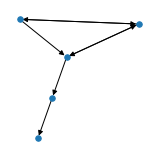

In [90]:
def plot_graph(gdict):
    """Utility: plots a graph from a gdict."""
    G = nx.Graph() # For layout only
    DG = nx.DiGraph()
    for node,edges in gdict.items():
        for other in edges:
            DG.add_edge(node, other)
            G.add_edge(node, other)
    pos=nx.kamada_kawai_layout(G)
    nx.draw(DG, node_size=30, pos=pos)
    return
    
def tinyfig():
    plt.figure(figsize=(2,2))
    
tinyfig()
plot_graph({0:[1,3], 1:[0,2], 2:[1,0], 3:[4]})

In [7]:
def profile(g):
    """Helper function. Returns nV, nE"""
    return (len(g), len(set([(i,j) for i,js in g.items() for j in js if i<j])))

profile({0:[1,2], 1:[0,2,4], 2:[1,0,4], 4:[1,2]})

(4, 5)

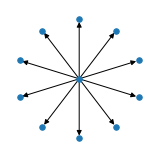

In [121]:
# Test subject: a star
def make_star(n=4):
    """Star with n-1 spikes."""    
    return {0:[i for i in range(1,n)]}

tinyfig()
plot_graph(make_star(11))

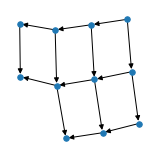

In [126]:
# Test subject 2: a grid
def make_grid(n=4):
    """Square grid of n elements."""
    m =  np.ceil(np.sqrt(n)).astype(int)    
    d = {i:[] for i in range(n)}
    address = lambda i,j: i*m + j
    for i in range(m):
        for j in range(m):                
            if address(i,j)>n: break
            if i < m-1: 
                k = address(i+1, j)
                if k<n: d[address(i,j)].append(k)
            if j < m-1: 
                k = address(i, j+1)
                if k<n: d[address(i,j)].append(k)
    return d

tinyfig()
plot_graph(make_grid(11))

(9, 12)

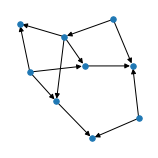

In [97]:
# Test subject 3: Random graph
def make_random(n, e=None):
    """Create oriented Erdos-like graph."""
    if e is None: e = 2*n
    edges = [(i,j) for j in range(n) for i in range(j) if i!=j] # Generate all possible edges
    edges = [edges[i] for i in np.random.choice(n*(n-1)//2, e, replace=False)] # Draw some
    g = {i:[j for k,j in edges if k==i] for i in range(n)}
    return g

tinyfig()
g = make_random(9,12)
plot_graph(g)
profile(g)

Now we'll try to preserve weakly connected half of the first graph. To do so, first calculate an undirected graph:

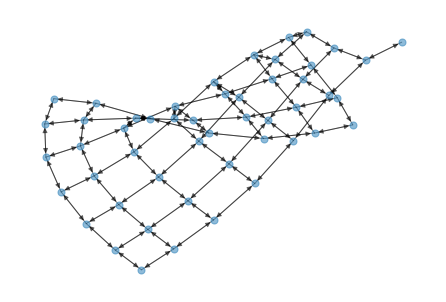

In [4]:
Asym = np.minimum(A.T+A,1) # Symmetric matrix to calculate recruitment

#plt.imshow(Asym, cmap="Greys")

G = nx.DiGraph()
G = nx.from_numpy_matrix(Asym,create_using=G)
nx.draw_spring(G,node_size=50,alpha=0.5,iterations=800)

Now propagate (percolate) on this undirected graph. If the graph is not connected, add points at random, and each time try to percolate further.

Note that we may get more than half of nodes, as last step may be overwhelming. If we overshot with this last step, we only use 50% of nodes that come with this last step, at random. It may still be more than half, but on average it will be about right, and it should make the process stable. (For example, a baby with a full graph will be a random graph, not a full graph, even though a full graph always overwhelms the algorithm on 2nd step).

Potentially a better approach would be to use first-breadth (or even first-depth) search instead of matrix multiplication, but for now this would suffice.

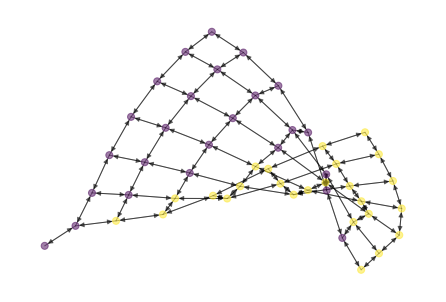

In [5]:
points = np.zeros(nNodes)
#points[np.random.choice(nNodes)] = 1
points[0]=1

newSum = 0
while newSum<nNodes/2:
    oldSum = np.sum(points)
    oldPoints = points.copy()
    points = np.minimum(1,points+np.matmul(Asym,points))
    newSum = np.sum(points)
    if newSum==oldSum: # If propagation no longer works, add stuff at random
        points[np.random.choice(nNodes)] = 1
    if newSum>nNodes/2: # we overshot
        points = np.maximum(oldPoints,np.multiply(points,np.random.choice(a=[0,1], size=nNodes)))
    
G = nx.DiGraph()
G = nx.from_numpy_matrix(Asym,create_using=G)
nx.draw_spring(G,node_size=50, node_color=points, alpha=0.5,iterations=800)

Now let's take all connections *between* selected points from the first graph (that is - all connections we used ot percolate on it), but all connections to and between unselected points from the second graph.

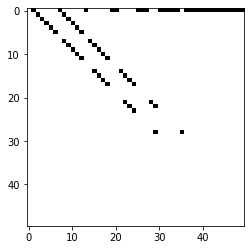

In [6]:
mask = np.outer(points,points)
Anew = np.multiply(A,mask) + np.multiply(B,1-mask)
    
plt.imshow(Anew, cmap="Greys")

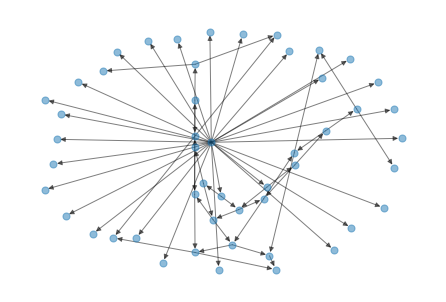

In [7]:
G = nx.DiGraph()
G = nx.from_numpy_matrix(Anew,create_using=G)
nx.draw_spring(G,node_size=50, alpha=0.5,iterations=800)